Dataset:

https://raw.githubusercontent.com/amankharwal/Website-data/master/data_banknote_authentication.txt

### Import Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

### Read the dataset

In [3]:
data = pd.read_csv("data_banknote_authentication.txt", header=None)
data.columns = ['var', 'skew', 'curt', 'entr', 'auth']
print(data.head())

       var    skew    curt     entr  auth
0  3.62160  8.6661 -2.8073 -0.44699     0
1  4.54590  8.1674 -2.4586 -1.46210     0
2  3.86600 -2.6383  1.9242  0.10645     0
3  3.45660  9.5228 -4.0112 -3.59440     0
4  0.32924 -4.4552  4.5718 -0.98880     0


### Data Exploration

In [4]:
print(data.info)

<bound method DataFrame.info of           var      skew     curt     entr  auth
0     3.62160   8.66610  -2.8073 -0.44699     0
1     4.54590   8.16740  -2.4586 -1.46210     0
2     3.86600  -2.63830   1.9242  0.10645     0
3     3.45660   9.52280  -4.0112 -3.59440     0
4     0.32924  -4.45520   4.5718 -0.98880     0
...       ...       ...      ...      ...   ...
1367  0.40614   1.34920  -1.4501 -0.55949     1
1368 -1.38870  -4.87730   6.4774  0.34179     1
1369 -3.75030 -13.45860  17.5932 -2.77710     1
1370 -3.56370  -8.38270  12.3930 -1.28230     1
1371 -2.54190  -0.65804   2.6842  1.19520     1

[1372 rows x 5 columns]>


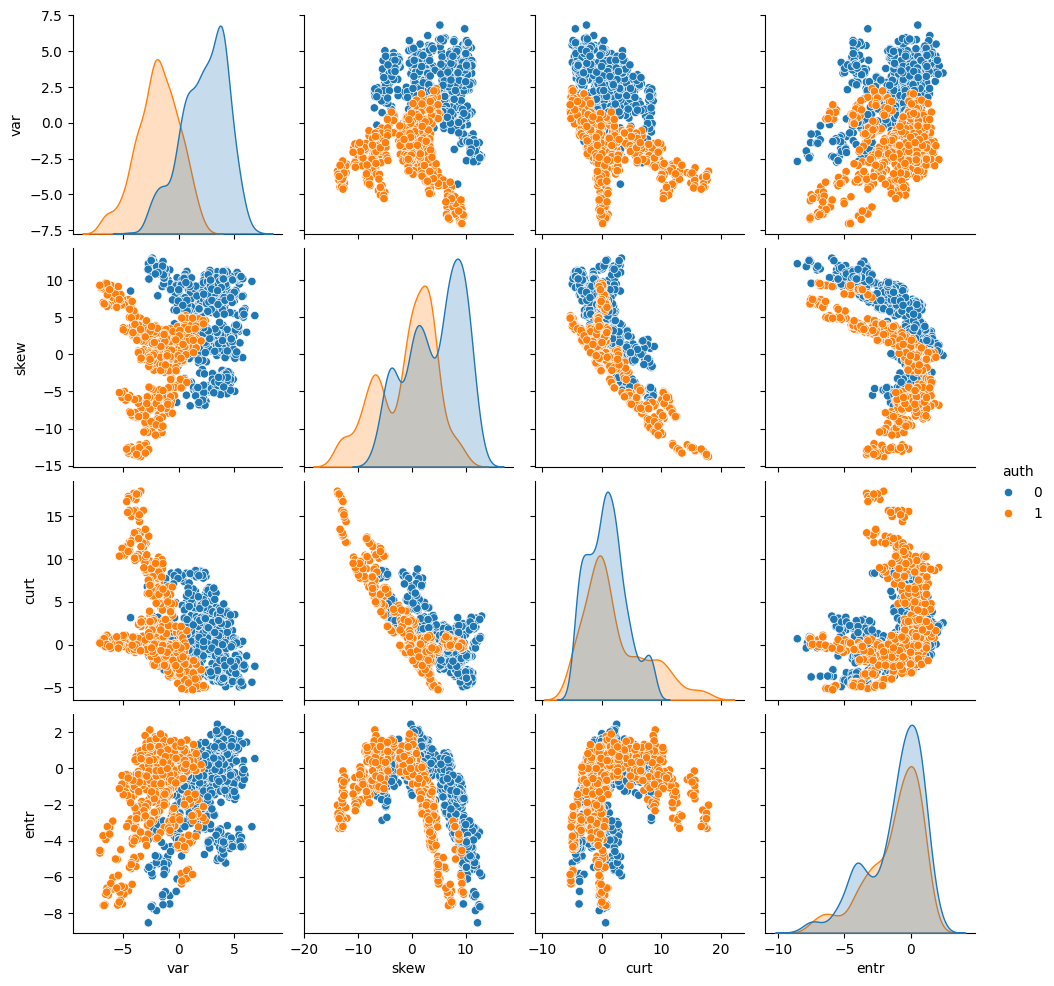

In [5]:
sns.pairplot(data, hue='auth')
plt.show()

From this pair plot we can make several interesting observations:

* The distribution of both variance and skewness appears to be quite different for the two target characteristics, while kurtosis and entropy appear to be more similar.

* There are clear linear and nonlinear trends in the input features.

* Some characteristics seem to be correlated.

* Some features seem to separate genuine and fake banknotes quite well.


Now let’s check if our data is balanced against the target values:

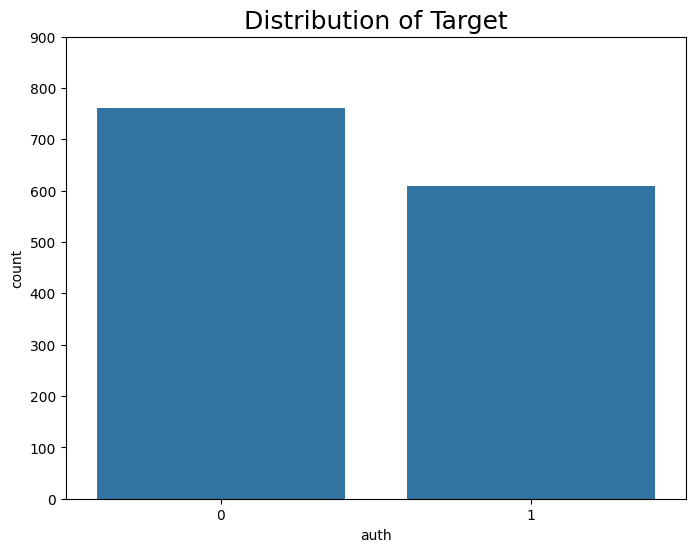

In [14]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Target', size=18)
sns.countplot(x=data['auth'])
target_count = data.auth.value_counts()
# plt.annotate(s=target_count[0], xy=(-0.04, 10+target_count[0]), size=14)
# plt.annotate(s=target_count[1], xy=(0.96, 10+target_count[1]), size=14)
plt.ylim(0,900)
plt.show()

The dataset is fairly balanced, but for the binary classification task, we need to balance it perfectly. So let’s start preprocessing the data by doing just that.

### Data Processing

Now we need to balance our data, the easiest way to do this is to randomly drop a number of instances of the overrepresented target function. This is called random undersampling.

Otherwise, we could also create new synthetic data for the under-represented target class. This is called oversampling. For now, let’s start by randomly deleting 152 observations of actual banknotes:

In [15]:
nb_to_delete = target_count[0] - target_count[1]
data = data.sample(frac=1, random_state=42).sort_values(by='auth')
data = data[nb_to_delete:]
print(data['auth'].value_counts())

auth
0    610
1    610
Name: count, dtype: int64


Now we have a perfectly balanced dataset. Next, we need to divide the data into training and test sets:

In [16]:
x = data.loc[:, data.columns != 'auth']
y = data.loc[:, data.columns == 'auth']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Now I will standardize the data by using the StandardScalar method provided by Scikit-learn:

In [17]:
scalar = StandardScaler()
scalar.fit(x_train)
x_train = scalar.transform(x_train)
x_test = scalar.transform(x_test)

### Logistic Regression for Fake Currency Detection

Now, I will train and test our model for fake currency detection by using the Logistic Regressing Algorithm. Let’s first fit the data on the Logistic Regression model to train the model:

In [18]:
clf = LogisticRegression(solver='lbfgs', random_state=42, multi_class='auto')
clf.fit(x_train, y_train.values.ravel())

LogisticRegression(random_state=42)

Now let’s test the accuracy of our model:

In [19]:
y_pred = np.array(clf.predict(x_test))
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                        columns=["Pred.Negative", "Pred.Positive"],
                        index=['Act.Negative', "Act.Positive"])
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = round((tn+tp)/(tn+tp+fn+fp), 4)
print(conf_mat)
print(f'\n Accuracy = {round(100*accuracy, 2)}%')

              Pred.Negative  Pred.Positive
Act.Negative            187              6
Act.Positive              0            173

 Accuracy = 98.36%


The logistic regression model achieved an accuracy of 98.36%. And not only that, when our fake currency detection model predicted that a banknote was real, it was correct 100% of the time.

Now let’s simulate the prediction of a single banknote. All we need to do is extract the features, scale them, and integrate them into our pre-trained model. We can also inspect the banknote probabilities of belonging to each target class:

In [22]:
new_banknote = np.array([4.5, -8.1, 2.4, 1.4], ndmin=2)
new_banknote = scalar.transform(new_banknote)
print(f'Prediction:  Class{clf.predict(new_banknote)[0]}')
print(f'Probability [0/1]:  {clf.predict_proba(new_banknote)[0]}')

Prediction:  Class0
Probability [0/1]:  [0.61151156 0.38848844]


Our model predicts that this banknote is real.

Source: https://thecleverprogrammer.com/2020/09/29/fake-currency-detection-with-machine-learning/